In [1]:
! pip install --quiet -U pdf2image pytesseract unstructured[all-docs] pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch langchain openai chromadb langchain-experimental
#! apt install poppler-utils
#! apt install tesseract-ocr

# Load and extract elements from the PDF

In [2]:
path = "LLaMA2/"
filename = "LLaMA2.pdf"

In [3]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=os.path.join(path, filename),
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=path,
)

# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1


# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())


class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Text count
text_elements = [e for e in categorized_elements if e.type == "text"]
print(f"Text: {len(text_elements)}")

# Tables count
table_elements = [e for e in categorized_elements if e.type == "table"]
print(f"Tables: {len(table_elements)}")

# Images count
image_count = len([name for name in os.listdir(path) if name.endswith(".jpg")])
print(f"Images: {image_count}")

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
2024-03-04 04:12:50.869873: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 04:12:50.915030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 04:12:50.915075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 04:12:50.917036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register 

Text: 114
Tables: 50
Images: 47


# Generate summaries of the texts and tables

In [4]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.callbacks.manager import get_openai_callback


# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Apply to texts
texts = [i.text for i in text_elements]
with get_openai_callback() as callback:
    text_summaries = summarize_chain.batch(texts)
    print(callback, end="\n\n")

# Apply to tables
tables = [i.text for i in table_elements]
with get_openai_callback() as callback:
    table_summaries = summarize_chain.batch(tables)
    print(callback, end="\n\n")

Tokens Used: 82222
	Prompt Tokens: 59927
	Completion Tokens: 22295
Successful Requests: 114
Total Cost (USD): $1.26812

Tokens Used: 28651
	Prompt Tokens: 17450
	Completion Tokens: 11201
Successful Requests: 50
Total Cost (USD): $0.5105299999999998



# Text retriever by understanding the summaries

In [5]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage.in_memory import InMemoryStore
from langchain_community.vectorstores.chroma import Chroma
from langchain_core.documents import Document
from langchain_openai.embeddings import OpenAIEmbeddings

# The text_vectorstore to use to index the child chunks
text_vectorstore = Chroma(
    collection_name=str(path.replace("/", "_")) + "text_vectorstore",
    embedding_function=OpenAIEmbeddings(),
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The text_retriever (empty to start)
text_retriever = MultiVectorRetriever(
    vectorstore=text_vectorstore,
    docstore=store,
    id_key=id_key,
    # search_kwargs={"k": 3},
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
text_retriever.vectorstore.add_documents(summary_texts)
text_retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s, metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
text_retriever.vectorstore.add_documents(summary_tables)
text_retriever.docstore.mset(list(zip(table_ids, tables)))

In [6]:
text_retriever.get_relevant_documents("What is the training tokens of LLaMA1 33B?")

['Table 1: Llama 2 family of models. Token counts refer to pretraining data only. All models are trained with a global batch-size of 4M tokens. Bigger models — 34B and 70B — use Grouped-Query Attention (GQA) for improved inference scalability.\n\n2.2 2.1 2.0 19 1.8 Train PPL 17 1.6 15 14 0 250 500 750 1000 1250 1500 1750 2000 Processed Tokens (Billions)\n\nFigure 5: Training Loss for Llama 2 models. We compare the training loss of the Llama 2 family of models. We observe that after pretraining on 2T Tokens, the models still did not show any sign of saturation.\n\nTokenizer. We use the same tokenizer as Llama 1; it employs a bytepair encoding (BPE) algorithm (Sennrich et al., 2016) using the implementation from SentencePiece (Kudo and Richardson, 2018). As with Llama 1, we split all numbers into individual digits and use bytes to decompose unknown UTF-8 characters. The total vocabulary size is 32k tokens.\n\n2.2.1 Training Hardware & Carbon Footprint\n\nTraining Hardware. We pretrained 

# Image retriever and image processing

In [7]:
import base64
import io

from IPython.display import HTML
from PIL import Image


def resize_base64_image(base64_string, max_size=(512, 512)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    max_size (tuple): Desired maximum size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Calculate the new size maintaining the aspect ratio
    original_width, original_height = img.size
    ratio = min(max_size[0] / original_width, max_size[1] / original_height)
    new_size = (int(original_width * ratio), int(original_height * ratio))

    # Resize the image
    resized_img = img.resize(new_size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def plt_img_base64(img_base64, max_size=(512, 512)):
    # Resize the image before displaying
    resized_img_base64 = resize_base64_image(img_base64, max_size=max_size)

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{resized_img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [8]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings


# Create chroma
image_vectorstore = Chroma(
    collection_name=str(path.replace("/", "_")) + "image_vectorstore",
    embedding_function=OpenCLIPEmbeddings(),
)

# Add images
# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(path, image_name) for image_name in os.listdir(path) if image_name.endswith(".jpg")])
image_vectorstore.add_images(uris=image_uris)

# Make retriever
image_retriever = image_vectorstore.as_retriever(
    # search_kwargs={"k": 3},
)


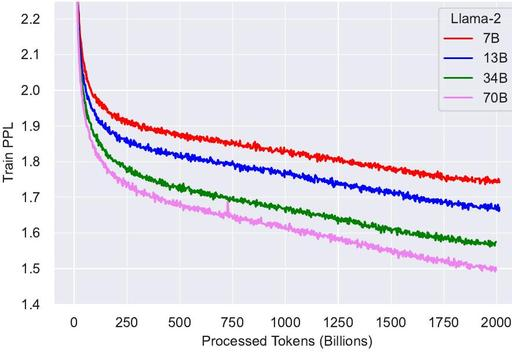


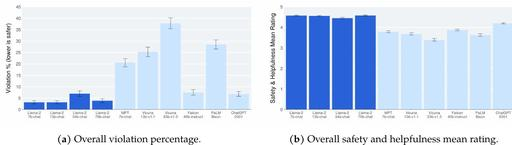


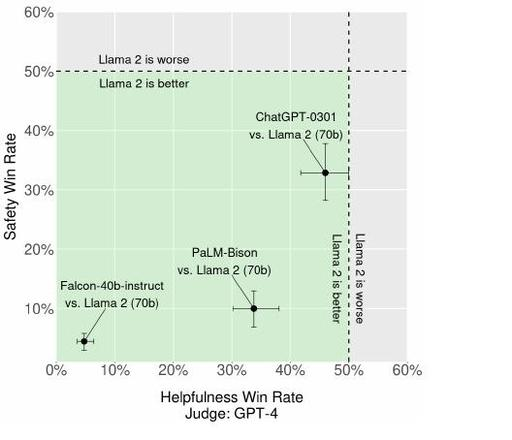


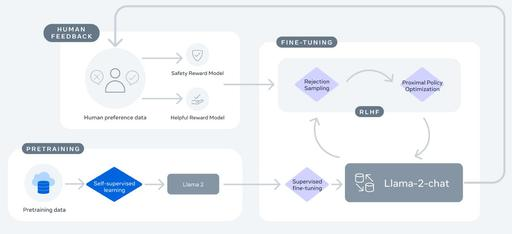

In [9]:
for doc in image_retriever.get_relevant_documents("What is the training tokens of LLaMA1 33B?"):
    plt_img_base64(doc.page_content)

# RAG chain with ensemble retriever

In [10]:
from operator import itemgetter

from langchain.retrievers.ensemble import EnsembleRetriever
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_openai.chat_models import ChatOpenAI


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"},
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As a secretary, your task is to extract and interpret both textual and visual information from the document, leveraging the rich context provided. The content has been sourced based on specific keywords input by the user."
            "**If the document does not contain direct references or clear data relevant to the user's query, you must clearly state 'No sufficient reference available to provide an answer' and refrain from answering further.**"
            f"Keywords provided by the user: {data_dict['question']}\n\n"
            "Extracted content:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(resize_base64_image(doc, max_size=(512, 512)))  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [11]:
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=4096)

ensemble_retriever = EnsembleRetriever(retrievers=[text_retriever, image_retriever], weights=[0.5, 0.5])

# RAG pipeline
chain = {
    "context": ensemble_retriever | RunnableLambda(split_image_text_types),
    "question": RunnablePassthrough(),
} | RunnableParallel(
    {
        "response": prompt_func | model | StrOutputParser(),
        "context": itemgetter("context"),
    }
)

# Helper function for Q&A

In [12]:
from langchain_community.callbacks.manager import get_openai_callback


def displayRAG(question):
    print("###QUESTION###")
    print(question, end="\n\n")

    with get_openai_callback() as callback:
        response = chain.invoke(question)
        print(callback, end="\n\n")

    print("###ANSWER###")
    print(response["response"], end="\n\n")

    for i, image in enumerate(response["context"]["images"]):
        print(f"###IMAGE{i+1}###")
        plt_img_base64(image)

    for i, text in enumerate(response["context"]["texts"]):
        print(f"###TEXT{i+1}###")
        print(text, end="\n\n")

###QUESTION###
What is the training tokens of LLaMA1 33B?

Tokens Used: 2274
	Prompt Tokens: 2146
	Completion Tokens: 128
Successful Requests: 1
Total Cost (USD): $0.0253

###ANSWER###
The user's query is about the training tokens of LLaMA1 33B. The extracted content provides information about the Llama 2 family of models and their training details, including the number of tokens they were trained on. According to the content, the Llama 1 models with parameters of 7B, 13B, 33B, and 65B were trained on 1.0T, 1.0T, 1.4T, and 1.4T tokens respectively. Therefore, the LLaMA1 33B model was pretrained on 1.4 trillion tokens.

###IMAGE1###



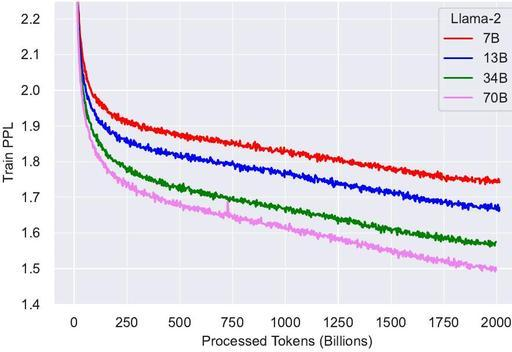

###IMAGE2###



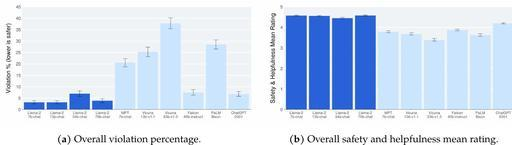

###IMAGE3###



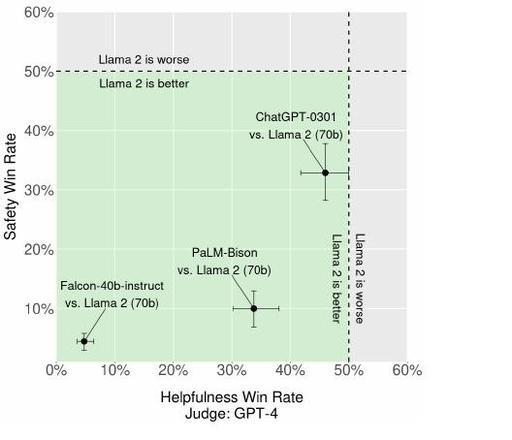

###IMAGE4###



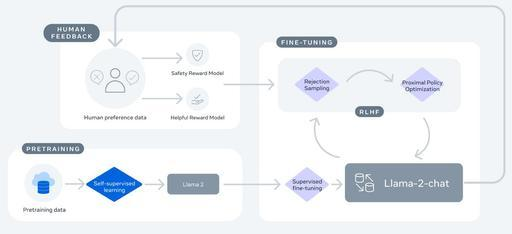

###TEXT1###
Table 1: Llama 2 family of models. Token counts refer to pretraining data only. All models are trained with a global batch-size of 4M tokens. Bigger models — 34B and 70B — use Grouped-Query Attention (GQA) for improved inference scalability.

2.2 2.1 2.0 19 1.8 Train PPL 17 1.6 15 14 0 250 500 750 1000 1250 1500 1750 2000 Processed Tokens (Billions)

Figure 5: Training Loss for Llama 2 models. We compare the training loss of the Llama 2 family of models. We observe that after pretraining on 2T Tokens, the models still did not show any sign of saturation.

Tokenizer. We use the same tokenizer as Llama 1; it employs a bytepair encoding (BPE) algorithm (Sennrich et al., 2016) using the implementation from SentencePiece (Kudo and Richardson, 2018). As with Llama 1, we split all numbers into individual digits and use bytes to decompose unknown UTF-8 characters. The total vocabulary size is 32k tokens.

2.2.1 Training Hardware & Carbon Footprint

Training Hardware. We pretrained 

In [13]:
displayRAG("What is the training tokens of LLaMA1 33B?")